0-1km

In [8]:
from tqdm import tqdm
road_length = 160000
def loc_conversion(value):
    return value*2

testList = [[0, loc_conversion(1000)], [loc_conversion(1000), loc_conversion(1000)+loc_conversion(2000)],[(int(road_length/2) - loc_conversion(500)), (int(road_length/2) + loc_conversion(500))], [(road_length-loc_conversion(1000)), road_length], [0, road_length]]
nameList = [[0, 1], ['1', '2'], ['Roadblock-500m', '+500'], ['15', '16'], ['0', '16']]

for index, item in tqdm(enumerate(testList), total=len(testList), desc="Processing"):
    section_start = item[0]
    section_end = item[1]
    start_name = nameList[index][0]
    end_name = nameList[index][1]
    
    print({section_start}, {section_end}, {start_name}, {end_name})

Processing: 100%|██████████| 5/5 [00:00<?, ?it/s]

{0} {2000} {0} {1}
{2000} {6000} {'1'} {'2'}
{79000} {81000} {'Roadblock-500m'} {'+500'}
{158000} {160000} {'15'} {'16'}
{0} {160000} {'0'} {'16'}


In [2]:
filename = 'data/ranged/ACCnormal_SHCnormal_RoadNone_RampIn0_VehIn1000_ranged.json'
name = f"{filename}km.png"
save_name = name.replace("data/ranged/", "").replace(".json", "")
print(save_name)

ACCnormal_SHCnormal_RoadNone_RampIn0_VehIn1000_rangedkm.png


In [3]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from common.config import road_params

# 1m : 2px
def loc_conversion(value):
    return value*2

# filename = "data/1000_vehicles/ACCnormal_SHCnormal_RoadNo_RampIn0_VehIn4000_0.json"

folderpath = "data/1000_vehicles/"

# Iterate through the files in the folder
for filename in os.listdir(folderpath):
    if filename.endswith('.json'):
        json_path = os.path.join(folderpath, filename)
        
        print("Executing:", json_path)
        
        # Read JSON file
        with open(json_path, 'r') as json_file:
            json_data = json.load(json_file)
            
        # Convert data to a flat list of dictionaries
        flat_data = []
        for frame_key, frame_data in json_data.items():
            for vehicle in frame_data:
                flat_data.append({
                    'frame': int(frame_key),
                    'uuid': vehicle['uuid'],
                    'vehicle_type': vehicle['vehicle_type'],
                    'location': vehicle['location'],
                    'speed': vehicle['speed'],
                    'timestamp': vehicle['timestamp']
                })
        # Create a DataFrame from the flat data
        df = pd.DataFrame(flat_data)

        # Filter rows based on x-coordinate range
        section_start = 0
        section_end = section_start + loc_conversion(1000)
        filtered_df = df[df['location'].apply(lambda loc: section_start <= loc[0] <= section_end)]

        # Converting pixel/second -> kmph
        filtered_df.loc[:,'speed']= filtered_df['speed'] * (3600/2000) # Converts back to kmph

        # Remove unnecessary columns 
        dropped_df = filtered_df.drop(['vehicle_type', 'location', 'timestamp'], axis=1)

        # Counting Vehicle Density = vehicles/km per frame
        dropped_df['num_vehicles'] = dropped_df.groupby('frame', as_index=False)['uuid'].transform('nunique')
        dropped_df = dropped_df.drop(['uuid'], axis=1)

        # Counting Space mean speed per frame
        dropped_df['average_speed'] = dropped_df.groupby('frame', as_index=False)['speed'].transform('mean')
        result_df = dropped_df.drop_duplicates(subset=['frame'])
        sorted_df = result_df.sort_values('frame')

        # Compute vehicle flow per km per frame
        sorted_df['flow'] = sorted_df['num_vehicles'].multiply(sorted_df['average_speed'])

        # Create a DataFrame from the flat data
        df = pd.DataFrame(flat_data)

        # Filter rows based on x-coordinate range
        section_start = 0
        section_end = section_end + loc_conversion(2000)
        filtered_df = df[df['location'].apply(lambda loc: section_start <= loc[0] <= section_end)]

        # Converting pixel/second -> kmph
        filtered_df.loc[:,'speed']= filtered_df['speed'] * (3600/2000) # Converts back to kmph

        # Remove unnecessary columns 
        dropped_df = filtered_df.drop(['vehicle_type', 'location', 'timestamp'], axis=1)

        # Counting Vehicle Density = vehicles/km per frame
        dropped_df['num_vehicles'] = dropped_df.groupby('frame', as_index=False)['uuid'].transform('nunique')
        dropped_df = dropped_df.drop(['uuid'], axis=1)

        # Counting Space mean speed per frame
        dropped_df['average_speed'] = dropped_df.groupby('frame', as_index=False)['speed'].transform('mean')
        result_df = dropped_df.drop_duplicates(subset=['frame'])
        sorted_df = result_df.sort_values('frame')

        # Compute vehicle flow per km per frame
        sorted_df['flow'] = sorted_df['num_vehicles'].multiply(sorted_df['average_speed'])
        
        # Compute traffic flow moving average across 10 frame intervals
        moving_average_flow_df = sorted_df['flow'].rolling(window=10).mean()
        cleaned_df = moving_average_flow_df.dropna(axis=0)
        moving_average_list = cleaned_df.tolist()

        num_vehicles = sorted_df['num_vehicles'].values.tolist()
        flow = sorted_df['flow'].values.tolist()

        # Plotting Data
        plt.figure(figsize=(12,8))

        # Plotting Vehicle Flow vs Vehicle Density
        plt.subplot(3,1,1)
        plt.scatter(num_vehicles, flow, 0.1)
        plt.xlabel('Vehicle Density (Vehicle/km)')
        plt.ylabel('Vehicle Flow (Vehicle/Hour)')
        plt.title('Vehicle Flow vs Vehicle Density from 0-1km')

        # Plotting Vehicle Flow vs Timestep
        plt.subplot(3,1,2)
        plt.scatter(range(len(flow)), flow, 0.1)
        plt.xlabel('Timestep')
        plt.ylabel('Vehicle Flow (Vehicle/Hour)')
        plt.title('Vehicle Flow vs Timestep from 0-1km')

        # Plotting Vehicle Flow Moving Average vs Timestep
        plt.subplot(3,1,3)
        plt.scatter(range(len(moving_average_list)), moving_average_list, 0.1)  # Adding markers for each data point
        plt.xlabel('Timestep')
        plt.ylabel('Flow Moving Average')
        plt.title('Plot of Vehicle Flow Moving Average from 0-1km')

        plt.tight_layout()
        name = f"{filename}0-1km.png"
        save_name = name.replace("data/", "").replace(".json", "").replace("1000_vehicles/", "100_vehicles_")
        plt.savefig(save_name)

Executing: data/1000_vehicles/ACCcautious_SHCirrational_RoadNo_RampIn0_VehIn4000.json
Executing: data/1000_vehicles/ACCcautious_SHCnormal_RoadNo_RampIn0_VehIn4000_0.json
Executing: data/1000_vehicles/ACCnormal_SHCirrational_RoadNo_RampIn0_VehIn4000.json
Executing: data/1000_vehicles/ACCnormal_SHCnormal_Roadleft_RampIn0_VehIn4000.json


1-2km

In [ ]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1m : 2px
def loc_conversion(value):
    return value*2

# filename = "data/1000_vehicles/ACCnormal_SHCnormal_RoadNo_RampIn0_VehIn4000_0.json"

folderpath = "data/1000_vehicles/"

# Iterate through the files in the folder
for filename in os.listdir(folderpath):
    if filename.endswith('.json'):
        json_path = os.path.join(folderpath, filename)
        
        # Read JSON file
        with open(json_path, 'r') as json_file:
            json_data = json.load(json_file)
            
        # Convert data to a flat list of dictionaries
        flat_data = []
        for frame_key, frame_data in json_data.items():
            for vehicle in frame_data:
                flat_data.append({
                    'frame': int(frame_key),
                    'uuid': vehicle['uuid'],
                    'vehicle_type': vehicle['vehicle_type'],
                    'location': vehicle['location'],
                    'speed': vehicle['speed'],
                    'timestamp': vehicle['timestamp']
                })
        # Create a DataFrame from the flat data
        df = pd.DataFrame(flat_data)

        # Filter rows based on x-coordinate range
        section_start = loc_conversion(1000)
        section_end = section_start + loc_conversion(1000)
        filtered_df = df[df['location'].apply(lambda loc: section_start <= loc[0] <= section_end)]

        # Converting pixel/second -> kmph
        filtered_df.loc[:,'speed']= filtered_df['speed'] * (3600/2000) # Converts back to kmph

        # Remove unnecessary columns 
        dropped_df = filtered_df.drop(['vehicle_type', 'location', 'timestamp'], axis=1)

        # Counting Vehicle Density = vehicles/km per frame
        dropped_df['num_vehicles'] = dropped_df.groupby('frame', as_index=False)['uuid'].transform('nunique')
        dropped_df = dropped_df.drop(['uuid'], axis=1)

        # Counting Space mean speed per frame
        dropped_df['average_speed'] = dropped_df.groupby('frame', as_index=False)['speed'].transform('mean')
        result_df = dropped_df.drop_duplicates(subset=['frame'])
        sorted_df = result_df.sort_values('frame')

        # Compute vehicle flow per km per frame
        sorted_df['flow'] = sorted_df['num_vehicles'].multiply(sorted_df['average_speed'])

        # Create a DataFrame from the flat data
        df = pd.DataFrame(flat_data)

        # Filter rows based on x-coordinate range
        section_start = loc_conversion(1000)
        section_end = section_end + loc_conversion(1000)
        filtered_df = df[df['location'].apply(lambda loc: section_start <= loc[0] <= section_end)]

        # Converting pixel/second -> kmph
        filtered_df.loc[:,'speed']= filtered_df['speed'] * (3600/2000) # Converts back to kmph

        # Remove unnecessary columns 
        dropped_df = filtered_df.drop(['vehicle_type', 'location', 'timestamp'], axis=1)

        # Counting Vehicle Density = vehicles/km per frame
        dropped_df['num_vehicles'] = dropped_df.groupby('frame', as_index=False)['uuid'].transform('nunique')
        dropped_df = dropped_df.drop(['uuid'], axis=1)

        # Counting Space mean speed per frame
        dropped_df['average_speed'] = dropped_df.groupby('frame', as_index=False)['speed'].transform('mean')
        result_df = dropped_df.drop_duplicates(subset=['frame'])
        sorted_df = result_df.sort_values('frame')

        # Compute vehicle flow per km per frame
        sorted_df['flow'] = sorted_df['num_vehicles'].multiply(sorted_df['average_speed'])
        
        # Compute traffic flow moving average across 10 frame intervals
        moving_average_flow_df = sorted_df['flow'].rolling(window=10).mean()
        cleaned_df = moving_average_flow_df.dropna(axis=0)
        moving_average_list = cleaned_df.tolist()

        num_vehicles = sorted_df['num_vehicles'].values.tolist()
        flow = sorted_df['flow'].values.tolist()

        # Plotting Data
        plt.figure(figsize=(12,8))

        # Plotting Vehicle Flow vs Vehicle Density
        plt.subplot(3,1,1)
        plt.scatter(num_vehicles, flow, 0.1)
        plt.xlabel('Vehicle Density (Vehicle/km)')
        plt.ylabel('Vehicle Flow (Vehicle/Hour)')
        plt.title('Vehicle Flow vs Vehicle Density from 1-2km')

        # Plotting Vehicle Flow vs Timestep
        plt.subplot(3,1,2)
        plt.scatter(range(len(flow)), flow, 0.1)
        plt.xlabel('Timestep')
        plt.ylabel('Vehicle Flow (Vehicle/Hour)')
        plt.title('Vehicle Flow vs Timestep from 1-2km')

        # Plotting Vehicle Flow Moving Average vs Timestep
        plt.subplot(3,1,3)
        plt.scatter(range(len(moving_average_list)), moving_average_list, 0.1)  # Adding markers for each data point
        plt.xlabel('Timestep')
        plt.ylabel('Flow Moving Average')
        plt.title('Plot of Vehicle Flow Moving Average from 1-2km')

        plt.tight_layout()
        name = f"{filename}1-2km.png"
        save_name = name.replace("data/", "").replace(".json", "").replace("1000_vehicles/", "100_vehicles_")
        plt.savefig(save_name)

At the road block, 500m before and after road block

In [ ]:
# 1m : 2px
def loc_conversion(value):
    return value*2

folderpath = "data/1000_vehicles/"

# Iterate through the files in the folder
for filename in os.listdir(folderpath):
    if filename.endswith('.json'):
        json_path = os.path.join(folderpath, filename)
        
        # Read JSON file
        with open(json_path, 'r') as json_file:
            json_data = json.load(json_file)
            
        # Convert data to a flat list of dictionaries
        flat_data = []
        for frame_key, frame_data in json_data.items():
            for vehicle in frame_data:
                flat_data.append({
                    'frame': int(frame_key),
                    'uuid': vehicle['uuid'],
                    'vehicle_type': vehicle['vehicle_type'],
                    'location': vehicle['location'],
                    'speed': vehicle['speed'],
                    'timestamp': vehicle['timestamp']
                })
        # Create a DataFrame from the flat data
        df = pd.DataFrame(flat_data)

        # Filter rows based on x-coordinate range
        section_start = loc_conversion(1000)
        section_end = section_start + loc_conversion(2000)
        filtered_df = df[df['location'].apply(lambda loc: section_start <= loc[0] <= section_end)]

        # Converting pixel/second -> kmph
        filtered_df.loc[:,'speed']= filtered_df['speed'] * (3600/2000) # Converts back to kmph

        # Remove unnecessary columns 
        dropped_df = filtered_df.drop(['vehicle_type', 'location', 'timestamp'], axis=1)

        # Counting Vehicle Density = vehicles/km per frame
        dropped_df['num_vehicles'] = dropped_df.groupby('frame', as_index=False)['uuid'].transform('nunique')
        dropped_df = dropped_df.drop(['uuid'], axis=1)

        # Counting Space mean speed per frame
        dropped_df['average_speed'] = dropped_df.groupby('frame', as_index=False)['speed'].transform('mean')
        result_df = dropped_df.drop_duplicates(subset=['frame'])
        sorted_df = result_df.sort_values('frame')

        # Compute vehicle flow per km per frame
        sorted_df['flow'] = sorted_df['num_vehicles'].multiply(sorted_df['average_speed'])

        # Create a DataFrame from the flat data
        df = pd.DataFrame(flat_data)

        # Filter rows based on x-coordinate range
        section_start = loc_conversion((road_params['road_length']/2) - loc_conversion(500))
        section_end = section_end + loc_conversion(1000)
        filtered_df = df[df['location'].apply(lambda loc: section_start <= loc[0] <= section_end)]

        # Converting pixel/second -> kmph
        filtered_df.loc[:,'speed']= filtered_df['speed'] * (3600/2000) # Converts back to kmph

        # Remove unnecessary columns 
        dropped_df = filtered_df.drop(['vehicle_type', 'location', 'timestamp'], axis=1)

        # Counting Vehicle Density = vehicles/km per frame
        dropped_df['num_vehicles'] = dropped_df.groupby('frame', as_index=False)['uuid'].transform('nunique')
        dropped_df = dropped_df.drop(['uuid'], axis=1)

        # Counting Space mean speed per frame
        dropped_df['average_speed'] = dropped_df.groupby('frame', as_index=False)['speed'].transform('mean')
        result_df = dropped_df.drop_duplicates(subset=['frame'])
        sorted_df = result_df.sort_values('frame')

        # Compute vehicle flow per km per frame
        sorted_df['flow'] = sorted_df['num_vehicles'].multiply(sorted_df['average_speed'])
        
        # Compute traffic flow moving average across 10 frame intervals
        moving_average_flow_df = sorted_df['flow'].rolling(window=10).mean()
        cleaned_df = moving_average_flow_df.dropna(axis=0)
        moving_average_list = cleaned_df.tolist()

        num_vehicles = sorted_df['num_vehicles'].values.tolist()
        flow = sorted_df['flow'].values.tolist()

        # Plotting Data
        plt.figure(figsize=(12,8))

        # Plotting Vehicle Flow vs Vehicle Density
        plt.subplot(3,1,1)
        plt.scatter(num_vehicles, flow, 0.1)
        plt.xlabel('Vehicle Density (Vehicle/km)')
        plt.ylabel('Vehicle Flow (Vehicle/Hour)')
        plt.title('Vehicle Flow vs Vehicle Density within 1km of roadblock')

        # Plotting Vehicle Flow vs Timestep
        plt.subplot(3,1,2)
        plt.scatter(range(len(flow)), flow, 0.1)
        plt.xlabel('Timestep')
        plt.ylabel('Vehicle Flow (Vehicle/Hour)')
        plt.title('Vehicle Flow vs Timestep within 1km of roadblock')

        # Plotting Vehicle Flow Moving Average vs Timestep
        plt.subplot(3,1,3)
        plt.scatter(range(len(moving_average_list)), moving_average_list, 0.1)  # Adding markers for each data point
        plt.xlabel('Timestep')
        plt.ylabel('Flow Moving Average')
        plt.title('Plot of Vehicle Flow Moving Average within 1km of roadblock')

        plt.tight_layout()
        name = f"{filename}roadblock.png"
        save_name = name.replace("data/", "").replace(".json", "").replace("1000_vehicles/", "100_vehicles_")
        plt.savefig(save_name)

In [ ]:
# import json
# import os
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # filename = "data/1000_vehicles/ACCnormal_SHCnormal_RoadNo_RampIn0_VehIn4000_0.json"

# folderpath = "data/1000_vehicles/"

# # Iterate through the files in the folder
# for filename in os.listdir(folderpath):
#     if filename.endswith('.json'):
#         json_path = os.path.join(folderpath, filename)
        
#         # Read JSON file
#         with open(json_path, 'r') as json_file:
#             json_data = json.load(json_file)
            
#             # Convert data to a flat list of dictionaries
#             flat_data = []
#             for frame_key, frame_data in data.items():
#                 for vehicle in frame_data:
#                     flat_data.append({
#                         'frame': int(frame_key),
#                         'uuid': vehicle['uuid'],
#                         'vehicle_type': vehicle['vehicle_type'],
#                         'location': vehicle['location'],
#                         'speed': vehicle['speed'],
#                         'timestamp': vehicle['timestamp']
#                     })
#             # Create a DataFrame from the flat data
#             df = pd.DataFrame(flat_data)

#             # Filter rows based on x-coordinate range
#             section_start = 1000
#             section_end = section_start + 2000
#             filtered_df = df[df['location'].apply(lambda loc: section_start <= loc[0] <= section_end)]

#             # Converting pixel/second -> kmph
#             filtered_df.loc[:,'speed']= filtered_df['speed'] * (3600/2000) # Converts back to kmph

#             # Remove unnecessary columns 
#             dropped_df = filtered_df.drop(['vehicle_type', 'location', 'timestamp'], axis=1)

#             # Counting Vehicle Density = vehicles/km per frame
#             dropped_df['num_vehicles'] = dropped_df.groupby('frame', as_index=False)['uuid'].transform('nunique')
#             dropped_df = dropped_df.drop(['uuid'], axis=1)

#             # Counting Space mean speed per frame
#             dropped_df['average_speed'] = dropped_df.groupby('frame', as_index=False)['speed'].transform('mean')
#             result_df = dropped_df.drop_duplicates(subset=['frame'])
#             sorted_df = result_df.sort_values('frame')

#             # Compute vehicle flow per km per frame
#             sorted_df['flow'] = sorted_df['num_vehicles'].multiply(sorted_df['average_speed'])

#             # Create a DataFrame from the flat data
#             df = pd.DataFrame(flat_data)

#             # Filter rows based on x-coordinate range
#             section_start = 1000
#             section_end = section_end + 2000
#             filtered_df = df[df['location'].apply(lambda loc: section_start <= loc[0] <= section_end)]

#             # Converting pixel/second -> kmph
#             filtered_df.loc[:,'speed']= filtered_df['speed'] * (3600/2000) # Converts back to kmph

#             # Remove unnecessary columns 
#             dropped_df = filtered_df.drop(['vehicle_type', 'location', 'timestamp'], axis=1)

#             # Counting Vehicle Density = vehicles/km per frame
#             dropped_df['num_vehicles'] = dropped_df.groupby('frame', as_index=False)['uuid'].transform('nunique')
#             dropped_df = dropped_df.drop(['uuid'], axis=1)

#             # Counting Space mean speed per frame
#             dropped_df['average_speed'] = dropped_df.groupby('frame', as_index=False)['speed'].transform('mean')
#             result_df = dropped_df.drop_duplicates(subset=['frame'])
#             sorted_df = result_df.sort_values('frame')

#             # Compute vehicle flow per km per frame
#             sorted_df['flow'] = sorted_df['num_vehicles'].multiply(sorted_df['average_speed'])
            
#             # Compute traffic flow moving average across 10 frame intervals
#             moving_average_flow_df = sorted_df['flow'].rolling(window=10).mean()
#             cleaned_df = moving_average_flow_df.dropna(axis=0)
#             moving_average_list = cleaned_df.tolist()

#             num_vehicles = sorted_df['num_vehicles'].values.tolist()
#             flow = sorted_df['flow'].values.tolist()

#             # Plotting Data
#             plt.figure(figsize=(12,8))

#             # Plotting Vehicle Flow vs Vehicle Density
#             plt.subplot(3,1,1)
#             plt.scatter(num_vehicles, flow, 0.1)
#             plt.xlabel('Vehicle Density (Vehicle/km)')
#             plt.ylabel('Vehicle Flow (Vehicle/Hour)')
#             plt.title('Vehicle Flow vs Vehicle Density from 1-2km')

#             # Plotting Vehicle Flow vs Timestep
#             plt.subplot(3,1,2)
#             plt.scatter(range(len(flow)), flow, 0.1)
#             plt.xlabel('Timestep')
#             plt.ylabel('Vehicle Flow (Vehicle/Hour)')
#             plt.title('Vehicle Flow vs Timestep from 1-2km')

#             # Plotting Vehicle Flow Moving Average vs Timestep
#             plt.subplot(3,1,3)
#             plt.scatter(range(len(moving_average_list)), moving_average_list, 0.1)  # Adding markers for each data point
#             plt.xlabel('Timestep')
#             plt.ylabel('Flow Moving Average')
#             plt.title('Plot of Vehicle Flow Moving Average from 1-2km')

#             plt.tight_layout()
#             name = f"{filename}.png"
#             save_name = name.replace("data/", "").replace(".json", "").replace("1000_vehicles/", "100_vehicles_")
#             plt.savefig(save_name)

In [ ]:
# with open(filename, 'r') as file:
#     data = json.load(file)

# # Convert data to a flat list of dictionaries
# flat_data = []
# for frame_key, frame_data in data.items():
#     for vehicle in frame_data:
#         flat_data.append({
#             'frame': int(frame_key),
#             'uuid': vehicle['uuid'],
#             'vehicle_type': vehicle['vehicle_type'],
#             'location': vehicle['location'],
#             'speed': vehicle['speed'],
#             'timestamp': vehicle['timestamp']
#         })

# # Create a DataFrame from the flat data
# df = pd.DataFrame(flat_data)

# # Filter rows based on x-coordinate range
# section_start = 1000
# section_end = section_end + 2000
# filtered_df = df[df['location'].apply(lambda loc: section_start <= loc[0] <= section_end)]

# # Converting pixel/second -> kmph
# filtered_df.loc[:,'speed']= filtered_df['speed'] * (3600/2000) # Converts back to kmph

# # Remove unnecessary columns 
# dropped_df = filtered_df.drop(['vehicle_type', 'location', 'timestamp'], axis=1)

# # Counting Vehicle Density = vehicles/km per frame
# dropped_df['num_vehicles'] = dropped_df.groupby('frame', as_index=False)['uuid'].transform('nunique')
# dropped_df = dropped_df.drop(['uuid'], axis=1)

# # Counting Space mean speed per frame
# dropped_df['average_speed'] = dropped_df.groupby('frame', as_index=False)['speed'].transform('mean')
# result_df = dropped_df.drop_duplicates(subset=['frame'])
# sorted_df = result_df.sort_values('frame')

# # Compute vehicle flow per km per frame
# sorted_df['flow'] = sorted_df['num_vehicles'].multiply(sorted_df['average_speed'])

In [ ]:
# sorted_df

,frame,speed,num_vehicles,average_speed,flow
380,89,107.816049,1,107.816049,107.816049
390,90,107.832972,1,107.832972,107.832972
400,91,107.849840,1,107.849840,107.849840
410,92,107.866652,1,107.866652,107.866652
420,93,107.883410,1,107.883410,107.883410
...,...,...,...,...,...
6928008,16329,17.886669,149,22.283904,3320.301746
6928641,16330,17.956806,149,22.227092,3311.836710
6929274,16331,18.026771,149,22.169299,3303.225573
6929906,16332,18.096535,149,22.110913,3294.526092


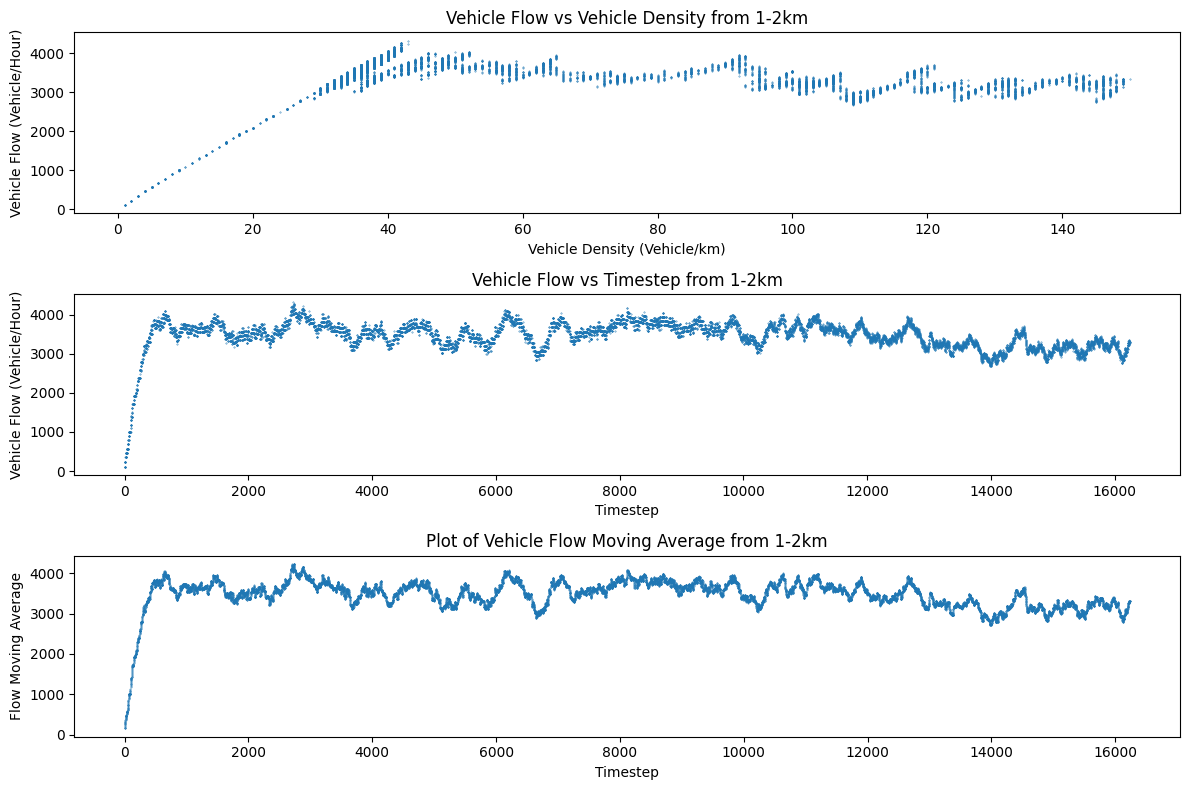

In [ ]:
# # Compute traffic flow moving average across 10 frame intervals
# moving_average_flow_df = sorted_df['flow'].rolling(window=10).mean()
# cleaned_df = moving_average_flow_df.dropna(axis=0)
# moving_average_list = cleaned_df.tolist()

# num_vehicles = sorted_df['num_vehicles'].values.tolist()
# flow = sorted_df['flow'].values.tolist()

# # Plotting Data
# plt.figure(figsize=(12,8))

# # Plotting Vehicle Flow vs Vehicle Density
# plt.subplot(3,1,1)
# plt.scatter(num_vehicles, flow, 0.1)
# plt.xlabel('Vehicle Density (Vehicle/km)')
# plt.ylabel('Vehicle Flow (Vehicle/Hour)')
# plt.title('Vehicle Flow vs Vehicle Density from 1-2km')

# # Plotting Vehicle Flow vs Timestep
# plt.subplot(3,1,2)
# plt.scatter(range(len(flow)), flow, 0.1)
# plt.xlabel('Timestep')
# plt.ylabel('Vehicle Flow (Vehicle/Hour)')
# plt.title('Vehicle Flow vs Timestep from 1-2km')

# # Plotting Vehicle Flow Moving Average vs Timestep
# plt.subplot(3,1,3)
# plt.scatter(range(len(moving_average_list)), moving_average_list, 0.1)  # Adding markers for each data point
# plt.xlabel('Timestep')
# plt.ylabel('Flow Moving Average')
# plt.title('Plot of Vehicle Flow Moving Average from 1-2km')

# plt.tight_layout()
# plt.show()

In [ ]:
# name = f"{filename}.png"
# save_name = name.replace("data/", "").replace(".json", "").replace("1000_vehicles/", "100_vehicles_")

In [ ]:
# plt.savefig(save_name)

<Figure size 640x480 with 0 Axes>